# Top Molecules identified by each SBVS Method

This notebook allows to visualize the **top $k$ molecules identified by each SBVS method**, i.e., the two machine learning models and the three consensus strategies.

<div class="alert alert-warning">
The ranking was computed from the $30 \times 4 cv$ results.
</div>

- $30 \times 4 cv$ results were computed in [this notebook](./2_30x4CV_analysis.ipynb). 
- See the cells below for a more detailed description about these results and how they were generated to **obtain a single molecular ranking**.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdDepictor
import matplotlib.pyplot as plt

In [14]:
protein_name = 'hsp90'

## Load the datasets
### Load the ensemble docking results

In [15]:
# Load the dataset
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1)
# Extract the response variable: Activity
y = df_dk_res['activity']

### Load the molecules saved as `rdkit` objects

In [16]:
# Load the dataframe with the rdkit molecules (no duplicates)
rdk_mols_file = '../2_Molecular_libraries/df_MOLECULES_no_duplicates.obj'
df_rdk_mols = pd.read_pickle(rdk_mols_file)
df_rdk_mols = df_rdk_mols.replace({'DEKOIS2': 'DEKOIS'})
df_rdk_mols = df_rdk_mols.set_index(['library', 'Lig'])

In [17]:
# Verify that both datasets match
assert np.all(X.index == df_rdk_mols.index)

## Load the `30x4cv` results
- This analysis was performed in the `2_30x4CV_analysis.ipynb` notebook.
- It contains the performance of the SBVS methods (ML and consensus strategies) of the 30x4cv analysis
- It also includes the information of each of the $120 \times 4$ validation sets:
    - The indices of the molecules used at each validation set.
    - The predictions of each of the SBVS methods:
        - The probabilities (*logits*) of the ML methods
        - The aggregation value determined by the consensus strategy.
        
- Results from other $30 \times 4 cv$ analysis can also be explored using this notebook, just change the `evaluation_name` variable:

```python
# Example
evaluation_name = f'{n_repeats}x{n_splits}cv_DEFAULT_HYPRMS'
```
- See the available $30 \times 4 cv$ results inside the `./cachedir` directory.

In [18]:
n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
filename = f'./cachedir/{evaluation_name}_{protein_name}'
cv30x4, y_preds, splits = joblib.load(filename)

#******************
#      NOTES
#******************

# cv30x4:  Are the results, per metric and per method, of the 30x4cv 

# y_preds: Is a dictionary where the key corresponds to the method's name
#          and the value is a list with the 120 predictions of the method
#          over the validation set. Each element of the list, is a numpy array
#.         with the predicions of the 25% of the molecules used for that
#          validation set. For the ML models, the values are the probabilities
#          returned by the classifier. For the Consensus scorings, the values
#.         are those resulting from the aggregation method applied over the raw
#          docking scores.

# splits:  is a list of 120 elements, where each element is a tuple where 
#          the second element is anumpy array with
#.         the indices of the molecules used for the validation sets.

# Therefore, each array inside y_preds contains the predictions of the method.

### Determine the rankings of each SBVS method after `30x4cv` analysis

In [19]:
def combine_cv_results(set_preds, k):
    '''
    Take `set_preds` which is a list of nxk elements,
    where each element is an array containing
    the indices of the samples comprising each validation
    set. 
    
    Returns a list of size 
    '''
    assert len(set_preds) % k == 0
    chunks = []
    for i in range(0, len(set_preds), k):
        chunks.append( set_preds[i: i+k])
    return chunks

In [20]:
# Number of validations sets = 120
n_val_sets   = n_repeats * n_splits
# Get only the validation sets
val_sets_ids = [i[1] for i in splits]

# List of results per method
m_preds_ranks = {}

for m_name in y_preds.keys():
    # Just get the validation set indices from the tuples
    # insidet the `splits` list
    set_preds = [
        pd.DataFrame(y_preds[m_name][i], 
                     index=val_set).rank(ascending=False)
         for i, val_set in enumerate(val_sets_ids)
    ]

    # Every k elements belong to 1 repeat of CV,
    # therefore, we can get the predictions per repeat
    # of all molecules using the `every_k_
    chunks = combine_cv_results(set_preds, k=n_splits)

    final_ranks = pd.concat([pd.concat(chunk, axis=0) 
                             for chunk in chunks], 
                            axis   = 1,
                            levels = None,
                            keys = range(1, n_repeats + 1))
    final_ranks.columns = final_ranks.columns.droplevel(1)
    final_ranks.columns.name = 'Repeats'
    final_ranks.index.name   = 'Molecules'

    # Add the labels: the y_true values
    mean_ranks = final_ranks.mean(axis = 1).to_frame(name='mean_rank')
    # Add the dataframe to the dictionary `m_preds_ranks`
    m_preds_ranks[m_name] = mean_ranks
# Convert the dictionary to a DataFrame
df_rank_preds = pd.concat(m_preds_ranks.values(), 
                          axis = 1, 
                          keys = y_preds.keys())
# For a better visualization of the table, let's format it
df_rank_preds.columns = df_rank_preds.columns.droplevel(1)
df_rank_preds = df_rank_preds.rank().astype('int')
Activities_list = ['Active' if i else 'Inactive' for i in y.values]
df_rank_preds.insert(loc = 0, column = 'Activity', value = Activities_list)
df_rank_preds.index = y.index
df_rank_preds.index.names = ['Library', 'Lig. Name']
df_rank_preds.columns.names = ['Ranking']
# Update the name of the columns
df_rank_preds = df_rank_preds.rename(columns = {'ml_lr'  : 'LR',
                      'ml_xgb' : 'GBT',
                      'ml_dclf': 'Dcfl',
                      'cs_MEAN': 'csAVG',
                      'cs_GEOM': 'csGEOM',
                      'cs_MIN' : 'csMIN'})

## Correlations between ranks

In [31]:
methods = ['LR','GBT','csAVG','csGEOM','csMIN']
# Correlation over the full set
df_corr = df_rank_preds[methods].corr(method = 'kendall').round(3)
df_corr

Ranking,LR,GBT,csAVG,csGEOM,csMIN
Ranking,,,,,
LR,1.000,0.526,0.028,0.021,0.052
GBT,0.526,1.000,0.053,0.037,0.103
csAVG,0.028,0.053,1.000,0.950,0.693
csGEOM,0.021,0.037,0.950,1.000,0.653
csMIN,0.052,0.103,0.693,0.653,1.000


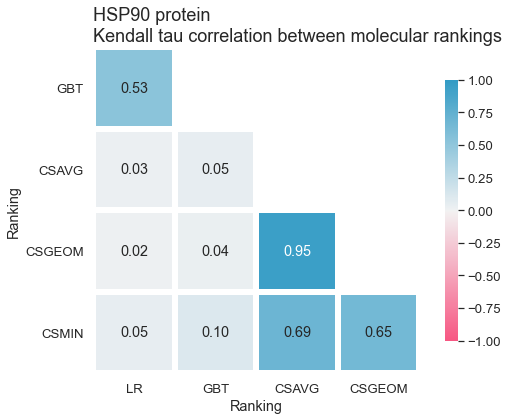

In [33]:
sns.set(style='whitegrid', font_scale = 1.2)
fig, ax = plt.subplots(figsize=(9, 6))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# color map
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .8}, square=True)
# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
# title
title = f'{protein_name.upper()} protein\n' +\
        "Kendall tau correlation between molecular rankings"
plt.title(title, loc='left', fontsize=18)
plt.savefig(f'{protein_name}_rankings.pdf')
plt.show()

## Draw the  top $k$ molecules of each SBVS method

In [23]:
# Define a function to draw the top molecules

def draw_top_mols_by_method(method, n_mols=9, 
                            subImgSize = (300, 220),
                            alignSubstructure = False):
    '''
    `df_rank_preds` and `df_rdk_mols` should be created. 
    '''
    # Get the top molecules by the given method
    df_top_mols_by_method = df_rank_preds.sort_values(method).head(n_mols)
    # Drop the Dummy classifier for simplicity
    df_top_mols_by_method = df_top_mols_by_method.drop('Dcfl', axis = 1)
    idx = (df_top_mols_by_method).index
    mols_rows = df_rdk_mols.loc[idx]
    # Verify the indices match
    assert np.all(df_top_mols_by_method.index == mols_rows.index)
    # Add extra data => MW, num atoms, num rot
    df_top_mols_by_method = pd.concat([df_top_mols_by_method, 
                                       mols_rows[['MW','num_atoms','num_rot']]], 
                                      axis = 1)
    # Get the mol objects
    mols = mols_rows['mol_rdk'].to_list()

    # Create the molecular labels
    mols_labels = [ f'{name} ({lib})' for lib, name
                    in mols_rows.index]
    mols_labels = [f'{ac} - {lb}' for ac, lb in 
                   zip(df_top_mols_by_method['Activity'], mols_labels)]
    # Convert to 2D for visualization
    for i in mols: AllChem.Compute2DCoords(i, canonOrient=True)

    # Get the common cores
    match_all = rdFMCS.FindMCS(mols, completeRingsOnly = False,
                               bondCompare=Chem.rdFMCS.BondCompare.CompareAny)
    # Convert to mol objects
    mcs_all = Chem.MolFromSmarts(match_all.smartsString)
    if alignSubstructure:
        # Aling molecules to the Maximum common substructure
        AllChem.Compute2DCoords(mcs_all)
        subms = [x for x in mols 
                     if x.HasSubstructMatch(
                      mcs_all
                     )]
        for m in mols:
            _ = AllChem\
            .GenerateDepictionMatching2DStructure(m, mcs_all)

    # Draw the molecules
    rdDepictor.SetPreferCoordGen(False)
    img = Chem.Draw.MolsToGridImage(
         mols,
         molsPerRow = 3,
         legends = mols_labels,
         useSVG=True,
         highlightAtomLists=[ mol.GetSubstructMatch(mcs_all) for mol in mols], 
         subImgSize = subImgSize)
    return img, df_top_mols_by_method

### Logistic Regression

Activity  LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                     
COCRYS  FGH          Active   1   14   1169    1645     15  434.604   
DUD     ligand_33    Active   2    1    604     552   1063  432.274   
DEKOIS  decoy_214  Inactive   3   36    344     320    678  504.651   
COCRYS  2QA          Active   4   23    397     687     11  390.527   
        2Q9          Active   5   20   1433    1836     29  435.592   
DUD     ligand_35    Active   5    2    423     363   1147  387.823   
COCRYS  73S          Active   7   32      3       4      4  453.893   
DEKOIS  decoy_211  Inactive   8  111   1524    1720    444  505.977   
COCRYS  YKI          Active   9   26      7      13      6  443.490   

                   num_atoms  num_rot  
Library Lig. Name                      
COCRYS  FGH               32        3  
DUD     ligand_33         27        5  
DEKOIS  decoy_214         37        7  
COCRYS  2QA               29        2  
        2Q9               32        3  
DUD     ligand_35         27        5  
COCRYS  73S               33        3  
DEKOIS  decoy_211         36        9  
COCRYS  YKI               34        3

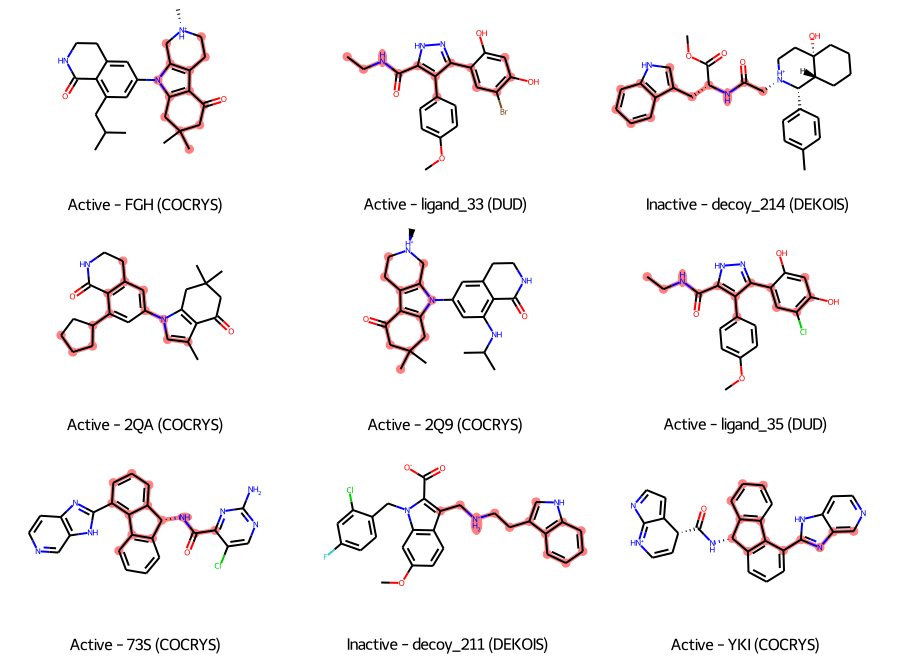

In [24]:
# Define the method
method = 'LR'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

### Gradient Boosting Trees

Activity   LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                     
DUD     ligand_33   Active    2    1    604     552   1063  432.274   
        ligand_35   Active    5    2    423     363   1147  387.823   
        ligand_31   Active   12    2    598     554   1127  373.796   
COCRYS  9ZC         Active   29    4    259     217    531  382.440   
DUD     ligand_37   Active   11    5    366     310   1227  401.850   
        ligand_25   Active   23    6    762     716    600  330.771   
COCRYS  2GG         Active   24    7    422     385    832  388.807   
DUD     ligand_5    Active   39    8    382     345    537  352.390   
COCRYS  06T         Active  550    9   1567    1946    146  494.660   

                   num_atoms  num_rot  
Library Lig. Name                      
DUD     ligand_33         27        5  
        ligand_35         27        5  
        ligand_31         26        4  
COCRYS  9ZC               28        4  
DUD     ligand_37         28        5  
        ligand_25         23        3  
COCRYS  2GG               27        5  
DUD     ligand_5          26        3  
COCRYS  06T               36        2

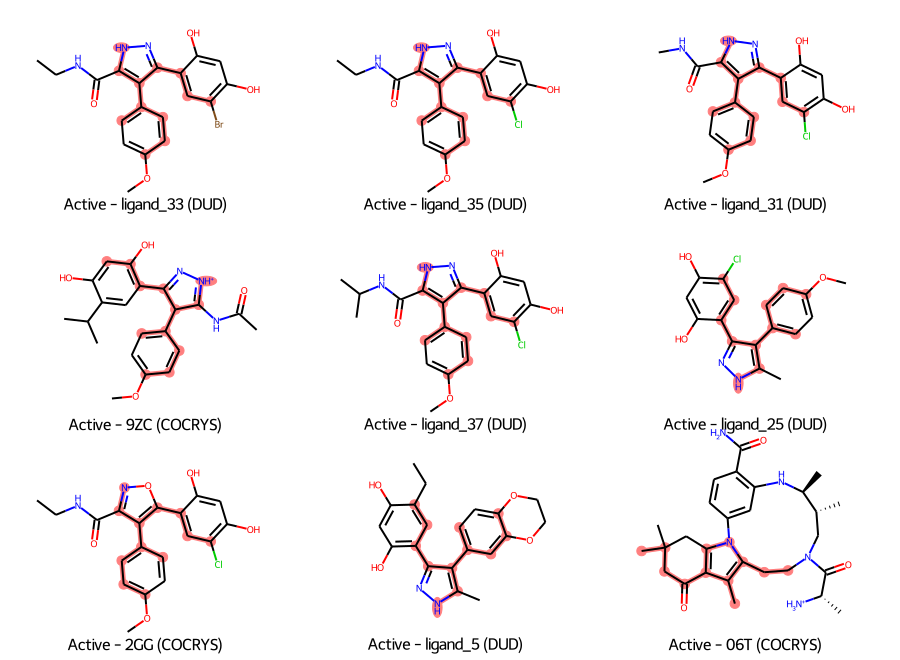

\begin{tabular}{lllrrrrrrrr}
\toprule
       &     & Activity &   LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &          &      &      &        &         &        &        &            &          \\
\midrule
DUD & ligand\_33 &   Active &    2 &    1 &    604 &     552 &   1063 &  432.3 &         27 &        5 \\
       & ligand\_35 &   Active &    5 &    2 &    423 &     363 &   1147 &  387.8 &         27 &        5 \\
       & ligand\_31 &   Active &   12 &    2 &    598 &     554 &   1127 &  373.8 &         26 &        4 \\
COCRYS & 9ZC &   Active &   29 &    4 &    259 &     217 &    531 &  382.4 &         28 &        4 \\
DUD & ligand\_37 &   Active &   11 &    5 &    366 &     310 &   1227 &  401.9 &         28 &        5 \\
       & ligand\_25 &   Active &   23 &    6 &    762 &     716 &    600 &  330.8 &         23 &        3 \\
COCRYS & 2GG &   Active &   24 &    7 &    422 &     385 &    832 &  388.8 &         27 &        5 

In [25]:
# Define the method
method = 'GBT'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Average Consensus strategy (csAVG)

Activity    LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                       
COCRYS  YKE          Active    66   49      1       1      1  453.505   
DEKOIS  ligand_24    Active   154  285      2       2     31  545.969   
COCRYS  73S          Active     7   32      3       4      4  453.893   
DEKOIS  decoy_165  Inactive    53   44      4       3     14  391.383   
        decoy_62   Inactive  1922  342      5       5     12  465.533   
COCRYS  73Y          Active   214   56      6       7      2  532.401   
        YKI          Active     9   26      7      13      6  443.490   
DEKOIS  decoy_794  Inactive   489  143      8       6     44  526.500   
        decoy_566  Inactive  1172  210      9       8     16  443.385   

                   num_atoms  num_rot  
Library Lig. Name                      
COCRYS  YKE               35        3  
DEKOIS  ligand_24         38        8  
COCRYS  73S               33        3  
DEKOIS  decoy_165         29        4  
        decoy_62          35        4  
COCRYS  73Y               36        3  
        YKI               34        3  
DEKOIS  decoy_794         38        9  
        decoy_566         32        5

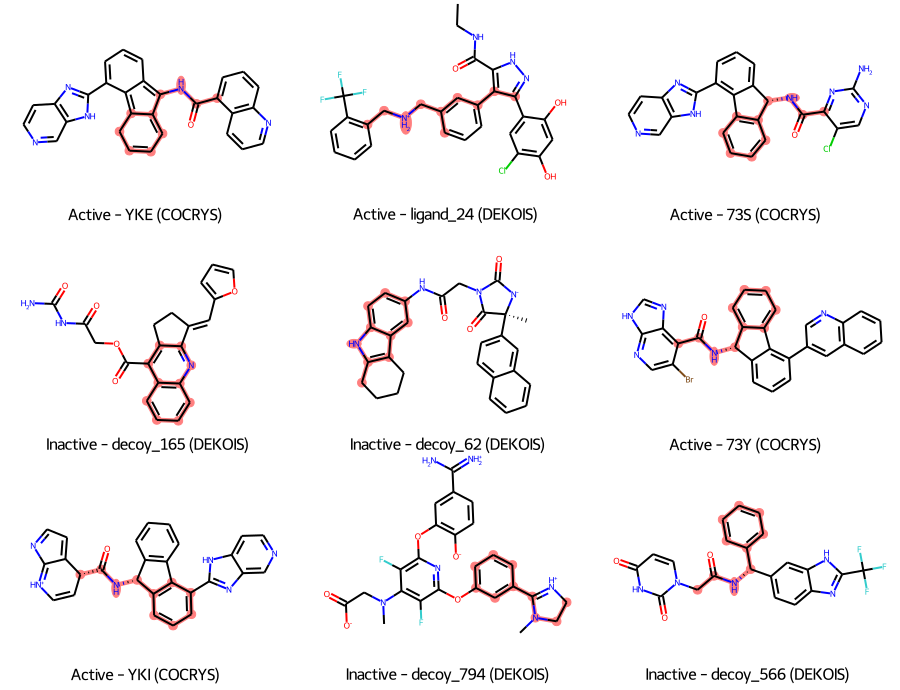

\begin{tabular}{lllrrrrrrrr}
\toprule
       &           &  Activity &    LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &       &      &        &         &        &        &            &          \\
\midrule
COCRYS & YKE &    Active &    66 &   49 &      1 &       1 &      1 &  453.5 &         35 &        3 \\
DEKOIS & ligand\_24 &    Active &   154 &  285 &      2 &       2 &     31 &  546.0 &         38 &        8 \\
COCRYS & 73S &    Active &     7 &   32 &      3 &       4 &      4 &  453.9 &         33 &        3 \\
DEKOIS & decoy\_165 &  Inactive &    53 &   44 &      4 &       3 &     14 &  391.4 &         29 &        4 \\
       & decoy\_62 &  Inactive &  1922 &  342 &      5 &       5 &     12 &  465.5 &         35 &        4 \\
COCRYS & 73Y &    Active &   214 &   56 &      6 &       7 &      2 &  532.4 &         36 &        3 \\
       & YKI &    Active &     9 &   26 &      7 &      13 &      6 &  443.5 &        

In [26]:
# Define the method
method = 'csAVG'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols, subImgSize = (300, 230))

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())

### Min Consensus strategy (csMIN)

Activity    LR  GBT  csAVG  csGEOM  csMIN       MW  \
Library Lig. Name                                                        
COCRYS  YKE           Active    66   49      1       1      1  453.505   
        73Y           Active   214   56      6       7      2  532.401   
        72K           Active  1686  181     75     103      3  491.595   
        73S           Active     7   32      3       4      4  453.893   
        YKJ           Active   315   40     13      51      5  418.460   
        YKI           Active     9   26      7      13      6  443.490   
        YKC           Active  1440  205     74     141      7  403.445   
        YKB           Active   112   33     22      68      8  397.438   
DEKOIS  decoy_1044  Inactive  2233  466    101     143      9  496.567   

                    num_atoms  num_rot  
Library Lig. Name                       
COCRYS  YKE                35        3  
        73Y                36        3  
        72K                37        5  
        73S                33        3  
        YKJ                32        3  
        YKI                34        3  
        YKC                31        3  
        YKB                30        5  
DEKOIS  decoy_1044         37        9

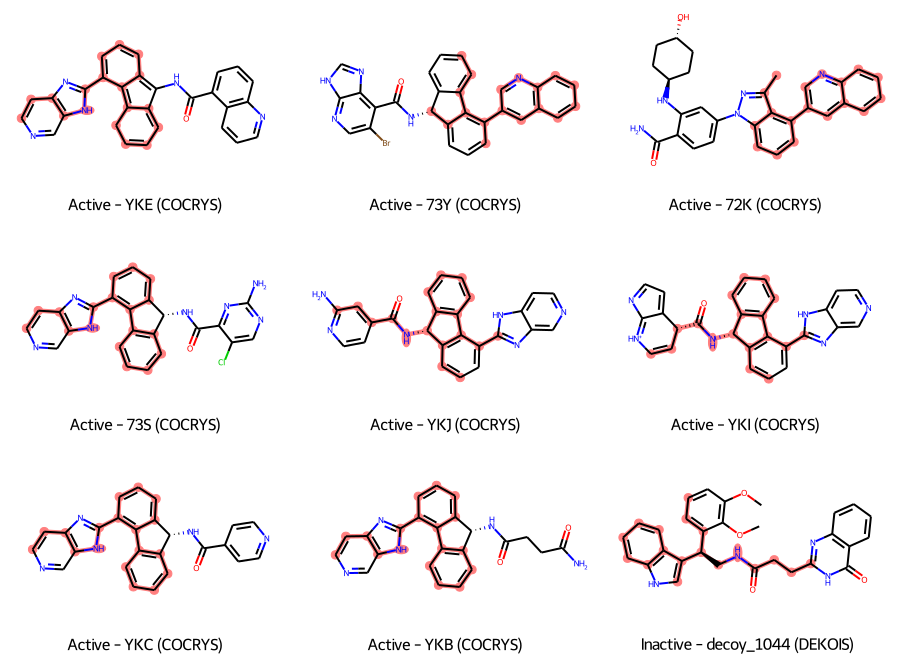

\begin{tabular}{lllrrrrrrrr}
\toprule
       &            &  Activity &    LR &  GBT &  csAVG &  csGEOM &  csMIN &     MW &  num\_atoms &  num\_rot \\
Library & Lig. Name &           &       &      &        &         &        &        &            &          \\
\midrule
COCRYS & YKE &    Active &    66 &   49 &      1 &       1 &      1 &  453.5 &         35 &        3 \\
       & 73Y &    Active &   214 &   56 &      6 &       7 &      2 &  532.4 &         36 &        3 \\
       & 72K &    Active &  1686 &  181 &     75 &     103 &      3 &  491.6 &         37 &        5 \\
       & 73S &    Active &     7 &   32 &      3 &       4 &      4 &  453.9 &         33 &        3 \\
       & YKJ &    Active &   315 &   40 &     13 &      51 &      5 &  418.5 &         32 &        3 \\
       & YKI &    Active &     9 &   26 &      7 &      13 &      6 &  443.5 &         34 &        3 \\
       & YKC &    Active &  1440 &  205 &     74 &     141 &      7 &  403.4 &         31 &        3 \\
 

In [27]:
# Define the method
method = 'csMIN'
n_mols = 9

img, df_top = draw_top_mols_by_method(method, n_mols=n_mols)

display(df_top)
display(img)

# Save for supplementary material
filename = f'{protein_name}_{n_mols}_topMols_{method}.svg'
with open(filename, 'w') as f:
    f.write(img.data)
    
print(df_top.round(1).to_latex())